In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Projects/ai_for_medicine

Mounted at /content/drive/
/content/drive/MyDrive/Projects/ai_for_medicine


In [2]:
# !git pull origin main

In [3]:
# !unzip Data/long_tumor_segmentation/processed.zip -d /content

In [4]:
from pathlib import Path
import torch
import numpy as np
import imgaug
from tqdm.notebook import tqdm
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [15]:
class LungTumorDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.all_files = self.extract_files(root)
        self.transform = transform

    @staticmethod
    def extract_files(root):
        files = []
        for sub in root.glob("*"):
          slice_path = sub/"data"
          for slice in slice_path.glob("*.npy"):
            files.append(slice)
        return files

    @staticmethod
    def change_img_path_label_path(path):
      parts = list(path.parts)
      parts[parts.index("data")] = "masks"
      return Path(*parts)

    def augment(self, slice, mask):
      random_seed = torch.randint(0, 100000, (1,))[0].item()
      imgaug.seed(random_seed)

      mask = SegmentationMapsOnImage(mask, shape=mask.shape)
      slice_aug, mask_aug = self.transform(image=slice, segmentation_maps=mask)
      mask_aug = mask_aug.get_arr()
      return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_path_label_path(file_path)

        slice = np.load(file_path)
        mask = np.load(mask_path).astype(np.uint8)

        if self.transform:
            slice, mask = self.augment(slice, mask)

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [16]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [17]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

In [18]:
train_path = Path("/content/processed/train")
val_path = Path("/content/processed/val")

train_dataset = LungTumorDataset(train_path, seq)
val_dataset = LungTumorDataset(val_path, None)

print(f"len of train images: {len(train_dataset)} and len of  val images: {len(val_dataset)}")


len of train images: 0 and len of  val images: 0


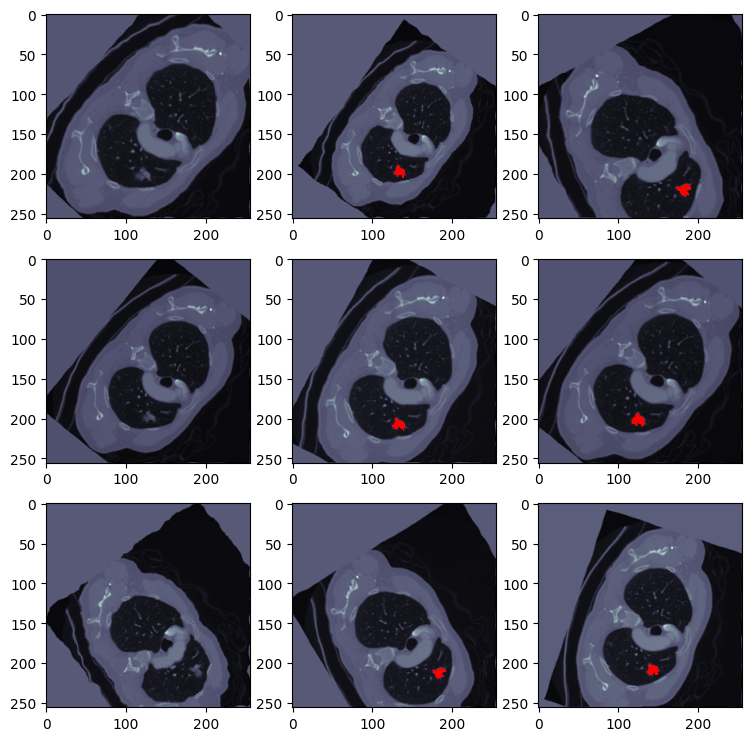

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
  for j in range(3):
    slice, mask = train_dataset[350]
    mask_ = np.ma.masked_where(mask == 0, mask)
    axis[i][j].imshow(slice[0], cmap="bone")
    if j == 0:
      continue
    axis[i][j].imshow(mask_[0], cmap="autumn")

In [ ]:
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/14360 [00:00<?, ?it/s]

In [ ]:
unique = np.unique(target_list, return_counts=True)
unique

(array([0, 1]), array([12797,  1563]))

In [ ]:
fraction = unique[1][0] / unique[1][1]
fraction

8.187460012795905

In [ ]:
weight_list = []

for target in target_list:
  if target == 0:
    weight_list.append(1)
  else:
    weight_list.append(fraction)

print(weight_list[:50])


[1, 1, 1, 8.187460012795905, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8.187460012795905, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8.187460012795905, 1, 1]


In [ ]:
sampler = torch.utils.data.WeightedRandomSampler(weight_list, len(weight_list))

In [ ]:
batch_size = 24
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
# for data, target in train_loader:
#   print(target.sum([1,2,3]))

In [5]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

In [6]:
class UNet(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = DoubleConv(1, 64)
    self.conv2 = DoubleConv(64, 128)
    self.conv3 = DoubleConv(128, 256)
    self.conv4 = DoubleConv(256, 512)

    self.conv5 = DoubleConv(512 + 256, 256)
    self.conv6 = DoubleConv(256 + 128, 128)
    self.conv7 = DoubleConv(128 + 64, 64)
    self.conv8 = torch.nn.Conv2d(64, 1, 1)

    self.maxpool = torch.nn.MaxPool2d(2)

  def forward(self, x):
    x1 = self.conv1(x)
    x1m = self.maxpool(x1)

    x2 = self.conv2(x1m)
    x2m = self.maxpool(x2)

    x3 = self.conv3(x2m)
    x3m = self.maxpool(x3)

    x4 = self.conv4(x3m)

    x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
    x5 = torch.cat([x5, x3], dim=1)
    x5 = self.conv5(x5)

    x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
    x6 = torch.cat([x6, x2], dim=1)
    x6 = self.conv6(x6)

    x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
    x7 = torch.cat([x7, x1], dim=1)
    x7 = self.conv7(x7)

    x8 = self.conv8(x7)

    return x8

In [7]:
model = UNet()

In [8]:
img = torch.randn(1, 1, 256, 256)
model(img).shape

torch.Size([1, 1, 256, 256])

In [9]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
class DiceLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, pred, mask):
    pred = torch.flatten(pred)
    mask = torch.flatten(mask)

    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() + 1e-8

    return 1 - ((2 * intersection) / union)

In [ ]:
model = UNet().to(device)
# criterion = DiceLoss().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)

In [ ]:
for epoch in range(15):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, masks in tqdm(train_loader):
        inputs, masks = inputs.float().to(device), masks.float().to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        # outputs = torch.sigmoid(outputs).to(device)

        loss = criterion(outputs, masks)  # Adjust the output shape if necessary
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, masks in val_loader:
            inputs, masks = inputs.float().to(device), masks.float().to(device)
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs).to(device)
            loss = criterion(outputs, masks)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.0315, Val Loss: 0.0029


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.0085, Val Loss: 0.0012


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.0054, Val Loss: 0.0024


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.0035, Val Loss: 0.0009


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.0027, Val Loss: 0.0007


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.0022, Val Loss: 0.0003


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.0021, Val Loss: 0.0004


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.0018, Val Loss: 0.0003


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.0018, Val Loss: 0.0003


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.0015, Val Loss: 0.0006


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.0016, Val Loss: 0.0003


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0015, Val Loss: 0.0005


  0%|          | 0/599 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0013, Val Loss: 0.0003


  0%|          | 0/599 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_save_path = 'models/lung_tumor_segmentation_UNet.pth'
torch.save(model.state_dict(), model_save_path)

In [10]:
model.load_state_dict(torch.load('models/lung_tumor_segmentation_UNet.pth'))

<All keys matched successfully>

In [11]:
class DiceLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, pred, mask):
    pred = torch.flatten(pred)
    mask = torch.flatten(mask)

    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() + 1e-8

    return 1 - ((2 * intersection) / union)

In [12]:
# !pip install celluloid

In [13]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera
import cv2

In [23]:
preds = []
labels = []

for inputs, mask in tqdm(val_dataset):
    inputs = torch.tensor(inputs).to(device).unsqueeze(0)

    with torch.no_grad():
      pred = model(inputs.float())
    pred = torch.sigmoid(pred).to(device)

    preds.append(pred.cpu().numpy())
    labels.append(mask)

pred = np.array(preds)
labels = np.array(labels)

0it [00:00, ?it/s]

In [20]:
loss = DiceLoss()
1 - loss(torch.from_numpy(pred), torch.from_numpy(labels))

tensor(0., dtype=torch.float64)

In [29]:
subject = "Data/long_tumor_segmentation/lung_002.nii.gz"
subject_ct = nib.load(subject).get_fdata()
subject_ct = subject_ct[:,:,30:]
subject_ct.shape

(512, 512, 239)

In [30]:
model = model.to(device)

In [31]:
segmentation = []
labels = []
scans = []

for i in range(subject_ct.shape[-1]):
  slice = subject_ct[:, :, i]
  slice = slice / 3071
  slice = cv2.resize(slice, (256, 256))
  slice = torch.tensor(slice).to(device)
  scans.append(slice)
  slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)

  with torch.no_grad():
        pred = model(slice)[0][0].cpu()
  pred = pred > 0.5
  segmentation.append(pred)
  labels.append(segmentation)


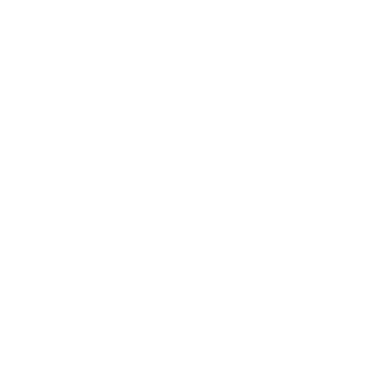

In [32]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scans), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scans[i].cpu(), cmap="bone")
    mask = np.ma.masked_where(segmentation[i].cpu()==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation

    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [33]:
from IPython.display import HTML
HTML(animation.to_html5_video())